# Revisión de resultados de Seurat

In [53]:
from sklearn.metrics import (calinski_harabasz_score, davies_bouldin_score, silhouette_score)
from scipy.optimize import linear_sum_assignment

from sklearn.decomposition import PCA
from sklearn import metrics
import pandas as pd
import numpy as np 
import pickle 

In [54]:
import matplotlib.pyplot as plt 
import seaborn as sns

# Funciones auxiliares

In [55]:
def cluster_acc_plot(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    y_pred = y_pred.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    
    df_cm = pd.DataFrame(w, index = [i for i in range(D)], columns = [i for i in range(D)])
    plt.figure(figsize = (10,7))
    w_order = np.zeros((D, D), dtype=np.int64)
    for i in range(D):
        for j in range(D):
            w_order[i,j] = w[i, ind[1][j]]

    df_cm = pd.DataFrame(w_order, index = [i for i in range(D)], columns = [i for i in ind[1]])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.ylabel("Prediction")
    plt.xlabel("Ground Truth")

In [56]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    y_pred = y_pred.astype(np.int64)

    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
        
    ind = linear_sum_assignment(w.max() - w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [57]:
def unsupervised_metrics(X, y_pred):
    # Evaluación final de resultados: métricas comparando con los clusters reales
    sil = np.round(silhouette_score(X, y_pred), 5)
    chs = np.round(calinski_harabasz_score(X, y_pred), 5)
    dbs = np.round(davies_bouldin_score(X, y_pred), 5)
    print('Evaluating cells: SIL= %.4f, CHS= %.4f, DBS= %.4f' % (sil, chs, dbs))

# Lectura de datos y resultados

In [58]:
# Datos iniciales

# ZI Poisson
with open('generados/zi_poisson_dim10000.pkl', 'rb') as f:
    poisson = pickle.load(f)
    X_p = poisson['X']
    y_p = np.array(poisson['y'])
    
# ZI Negative Binomial
with open('generados/zi_negative_binomial_dim10000.pkl', 'rb') as f:
    nb = pickle.load(f)
    X_nb = nb['X']
    y_nb = np.array(nb['y'])

In [59]:
# Resultados Seurat

clusters_p = pd.read_csv('generados/zi__poisson_dim10000/resultados/clusters.csv').seurat_clusters
clusters_nb = pd.read_csv('generados/zi_negative_binomial_dim10000/resultados/clusters.csv').seurat_clusters

# Métricas

#### Poisson

In [60]:
acc = round(cluster_acc(clusters_p, y_p),3)
nmi = round(metrics.normalized_mutual_info_score(clusters_p, y_p),3)
ari = round(metrics.adjusted_rand_score(clusters_p, y_p),3)

print(f"ACC: {acc}. NMI: {nmi}. ARI: {ari}.")

ACC: 0.855. NMI: 0.943. ARI: 0.886.


In [61]:
unsupervised_metrics(X_p, y_p)

Evaluating cells: SIL= 0.0641, CHS= 197.9162, DBS= 3.6413


In [62]:
X_p_pca = PCA(n_components=32).fit_transform(X_p)
unsupervised_metrics(X_p_pca, y_p)

Evaluating cells: SIL= 0.7466, CHS= 18991.4252, DBS= 0.3661


<Figure size 1000x700 with 0 Axes>

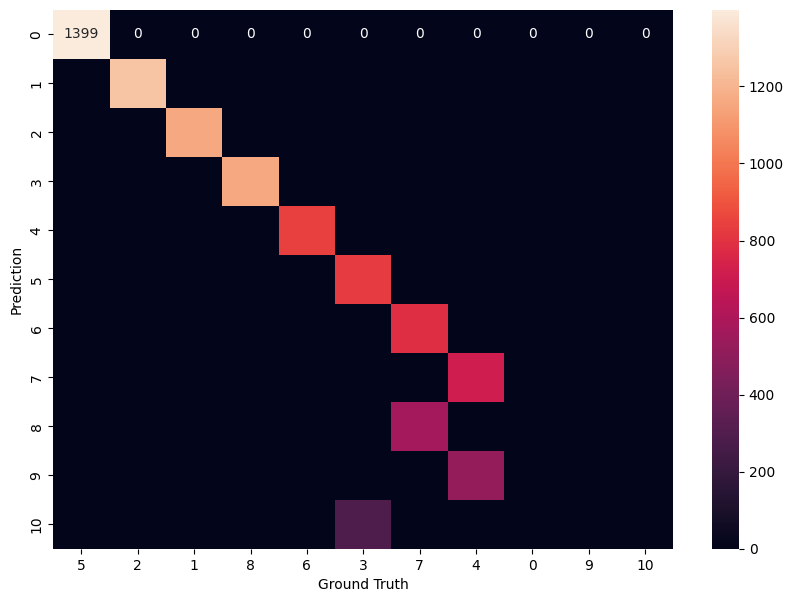

In [63]:
cluster_acc_plot(y_p, clusters_p)

#### Negative binomial

In [64]:
acc = round(cluster_acc(clusters_nb, y_nb),3)
nmi = round(metrics.normalized_mutual_info_score(clusters_nb, y_nb),3)
ari = round(metrics.adjusted_rand_score(clusters_nb, y_nb),3)

print(f"ACC: {acc}. NMI: {nmi}. ARI: {ari}.")

ACC: 0.752. NMI: 0.847. ARI: 0.732.


In [65]:
unsupervised_metrics(X_nb, y_nb)

Evaluating cells: SIL= -0.1286, CHS= 226.7533, DBS= 6.3627


In [66]:
X_nb_pca = PCA(n_components=32).fit_transform(X_nb)
unsupervised_metrics(X_nb_pca, y_nb)

Evaluating cells: SIL= 0.6407, CHS= 3922.7176, DBS= 0.7470


<Figure size 1000x700 with 0 Axes>

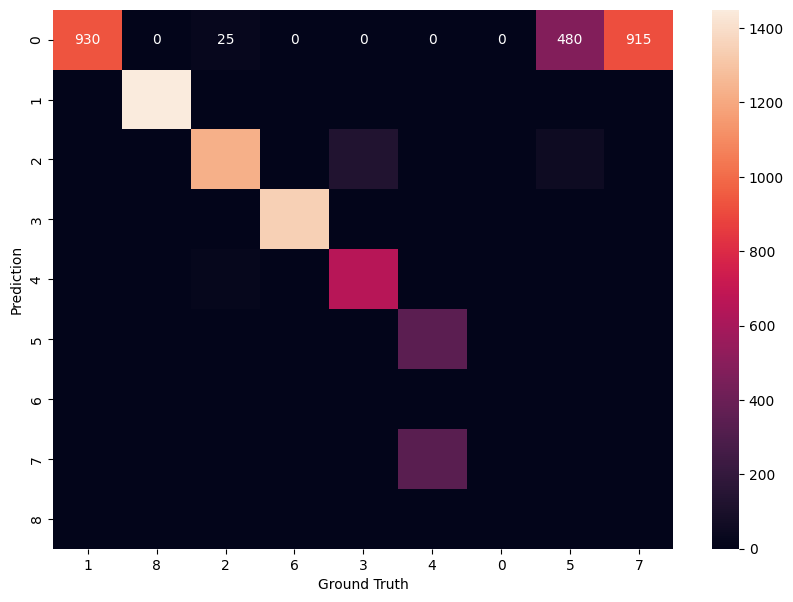

In [67]:
cluster_acc_plot(y_nb, clusters_nb)

### Conclusiones:

- Para aplicar métricas no supervisadas debe ser sobre la proyección (PCA) o sobre una dimensión menor.
- Seurat tiene un buen rendimiento sobre los datos de prueba.